In [1]:
import os
import shutil
import h5py
import numpy as np
from astropy.nddata.utils import Cutout2D
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
from astropy.visualization import (ZScaleInterval, ImageNormalize)
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
import umap
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
from functions import *
from create_models import *

# Create train, val and test sets

In [2]:
image_dir = "/home/anahoban/projects/rrg-kyi/astro/cfis/W3/"
label_dir = "/home/anahoban/scratch/stronglens/Code/Batch Loading/Currently used/labels/"
label_subdir = "stronglensdb_confirmed_unige/"

In [3]:
# If the hdf5 files already exist
cutout_dir = os.path.expandvars("$SCRATCH") + "/"
hf = h5py.File(cutout_dir + "confirmed_cfis_64p.h5", "r")

In [4]:
num_cands = 0
for tile in hf.keys():
    cutouts = list(hf[tile+'/IMAGES'].keys())
    for cut in cutouts:
        if cut[-1] in ['r','u']:
            num_cands += 1

KeyboardInterrupt: 

In [5]:
num_cands = 381 #computed from cell above
cutouts_size = 64

In [6]:
#candidate cutouts
conf_cand = np.zeros((num_cands, 64 ,64 , 4)) #just need u and r for now
count = 0
for tile in hf.keys():
    cutouts = list(hf[tile+'/IMAGES'].keys())
    for cut in cutouts:
        if cut[-1] in ['r','u']:
            conf_cand[count,...,:2] = np.array(hf[tile+'/IMAGES/'+cut])[...,[0,2]]
            if np.isnan(np.sum(conf_cand[count,...,0])): #u is nan
                conf_cand[count,...,0] = np.random.normal(loc = 0.5,scale= 0.13, size=(cutout_size, cutout_size))
            if np.isnan(np.sum(conf_cand[count,...,1])): #r is nan
                conf_cand[count,:,:,1] = np.random.normal(loc = 0.5,scale= 0.13, size=(cutout_size, cutout_size))
            count += 1          
count == num_cands #should be True

True

In [7]:
import random
#random cutouts
#for now, we want the same number of candidates as non candidates
with open('./cutouts/cutouts_adresses.csv', newline='') as f:
    reader = csv.reader(f)
    cutout_ids = list(reader)[0]

random.Random(5).shuffle(cutout_ids)

In [8]:
num_rand = num_cands*6 #number of random cutouts, ratio 1:1
rand_cuts = np.zeros((num_rand, 64 ,64 , 4)) #just need u and r for now
count = 0
for i in cutout_ids:
    tile, cut = i.split(' ')
    if cut[-1] not in ['r','u'] and count < num_rand:
        rand_cuts[count,...,:2 ] = np.array(hf[tile+'/IMAGES/'+cut])[...,[0,2]]
        count += 1
count == num_rand #should be True

True

In [9]:
#create label and full dataset
labels = np.concatenate((np.ones(num_cands),np.zeros(num_rand)))
cutouts = np.concatenate((conf_cand, rand_cuts))

(array([    0., 16384.,     0.]),
 array([-0.5       , -0.16666667,  0.16666667,  0.5       ]),
 <BarContainer object of 3 artists>)

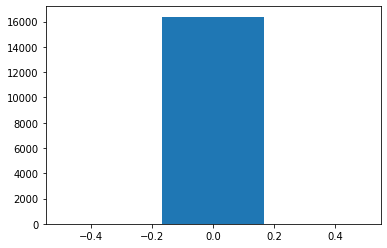

In [10]:
plt.hist((cutouts[0]-conf_cand[0]).flatten(), bins = 3) #making sure concat worked properly

In [11]:
from sklearn.utils import shuffle
X, Y = shuffle(cutouts, labels, random_state=0)

In [12]:
#splitting 70:20:10
train_x, val_x, test_x = np.split(X, [int(.7*len(Y)), int(.9*len(Y))])
train_y, val_y, test_y = np.split(Y, [int(.7*len(Y)), int(.9*len(Y))])

In [12]:
#checking in NAN
for cut in range(len(train_x)):
        if np.isnan(np.sum(train_x[cut])) == True:
            
            print('NAN found in training set, index', cut) 
        

---
# Getting latent space + u-mapping og data and latent space rep


In [13]:
#data for training classifier!!
len_test = len(test_x)

In [14]:
bands = 2
def MSE_with_uncertainty(y_true, y_pred): 
    weights = y_pred[...,bands:] 
    y_pred_image = y_pred[...,:bands]
    
    return K.square(tf.math.multiply((y_true - y_pred_image), weights) )

In [15]:
autoencoder_cfis = keras.models.load_model("../Models/job15.h5", custom_objects={'MSE_with_uncertainty': MSE_with_uncertainty})
encoder = keras.Model(autoencoder_cfis.input, autoencoder_cfis.layers[7].output)

--- 

In [16]:
import sklearn.datasets
import pandas as pd
import numpy as np
import umap.umap_ as umap
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [74]:
#sns.set_theme(context='poster', rc={'figure.figsize':(7,5)}, palette = sns.color_palette())

In [17]:
#2d
reducer = umap.UMAP(random_state=42)
mapper =reducer.fit(test_x.reshape(len_test,64*64*4))
embedding = reducer.transform(test_x.reshape(len_test,64*64*4))

data = test_x.reshape(len_test,64*64*4)

In [18]:
data_list = test_y
def draw_umap(data, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=data_list)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=data_list)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=data_list, s=100)
    plt.title(title, fontsize=18)

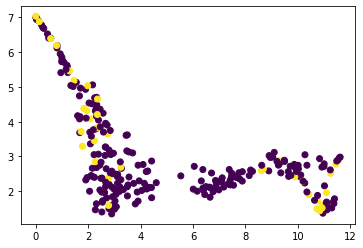

In [19]:
plt.scatter(embedding[:,0], embedding[:,1], c=test_y)

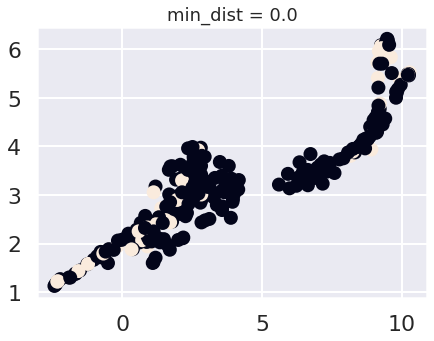

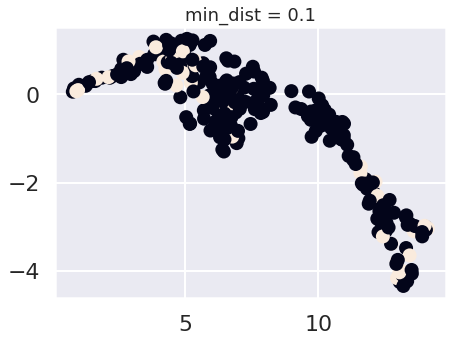

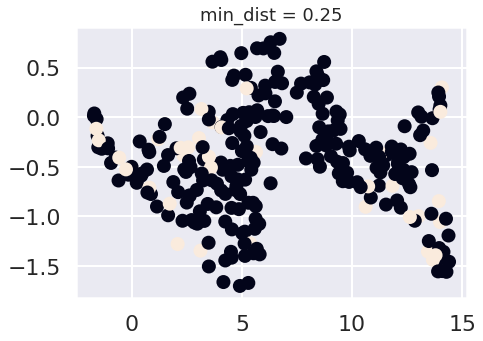

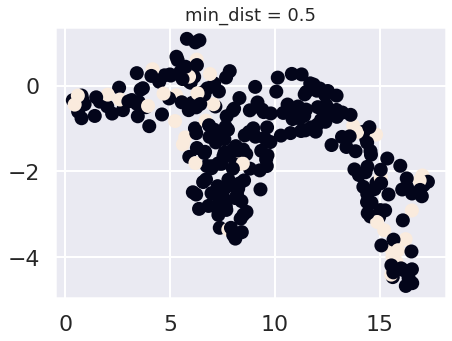

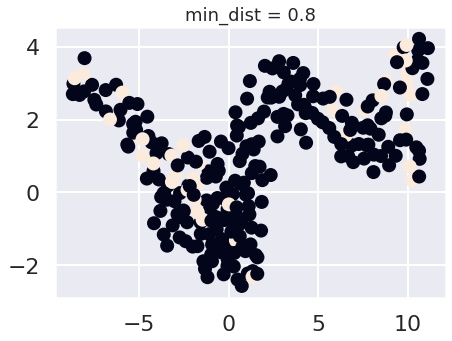

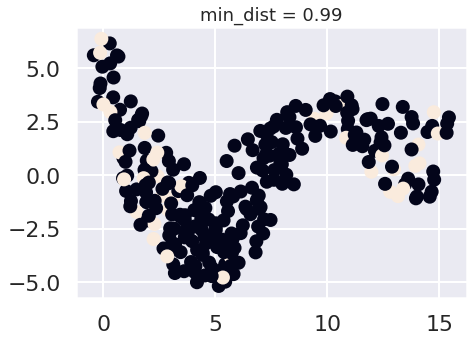

In [81]:
for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
    draw_umap(data, min_dist=d, title='min_dist = {}'.format(d))

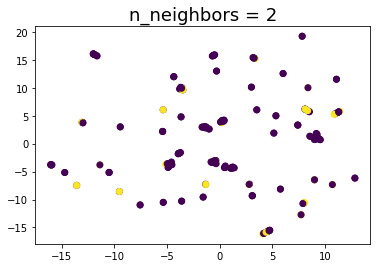

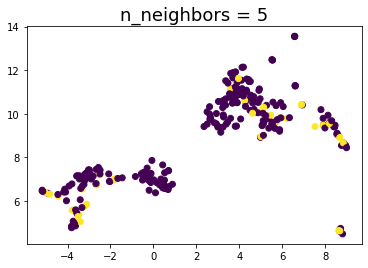

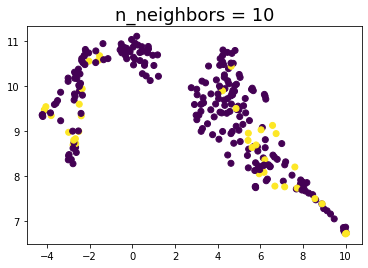

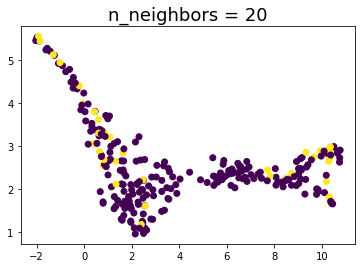

In [27]:
for n in (2, 5, 10, 20):
    draw_umap(data, n_neighbors=n, title='n_neighbors = {}'.format(n))

In [41]:
#3d
reducer3d = umap.UMAP(random_state=42, n_components = 3)
reducer3d.fit(latent_x.reshape(len_test, 64*64*32))
embedding3d = reducer3d.transform(latent_x.reshape(len_test,64*64*32))

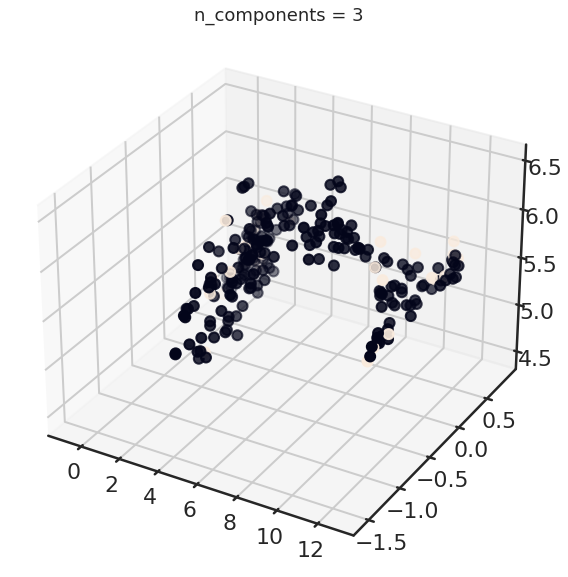

In [46]:
draw_umap(n_components=3, title='n_components = 3')

---
## on latent space

In [26]:
latent_x = encoder.predict(test_x)
len_test= len(latent_x)
data = latent_x.reshape(len_test,64*64*32)

In [25]:
latent_x = encoder.predict(train_x)
len_train= len(latent_x)
data = latent_x.reshape(len_train,64*64*32)

KeyboardInterrupt: 

In [27]:
#2d
reducer = umap.UMAP(random_state=42)
mapper =reducer.fit(latent_x.reshape(len_test,64*64*32))
embedding = reducer.transform(latent_x.reshape(len_test,64*64*32))

In [21]:
#2d
reducer = umap.UMAP(random_state=42)
mapper =reducer.fit(latent_x.reshape(len_test,64*64*32))
embedding = reducer.transform(latent_x.reshape(len_test,64*64*32))

/home/anahoban/lensing/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


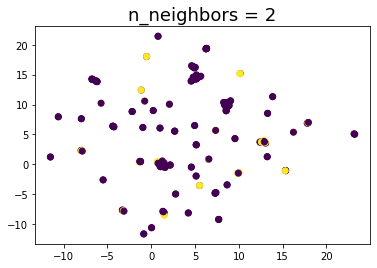

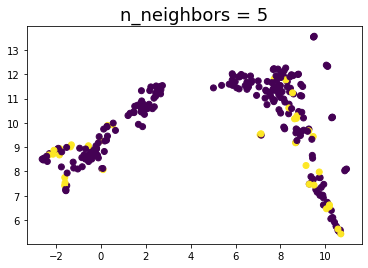

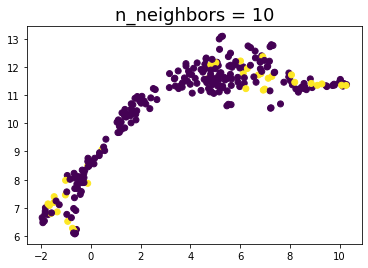

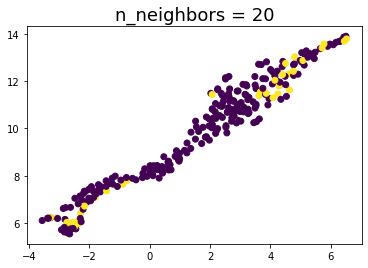

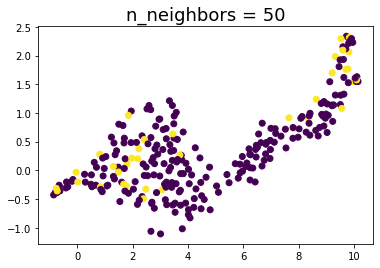

In [28]:
data_list = test_y
for n in (2, 5, 10, 20, 50):
    draw_umap(data, n_neighbors=n, title='n_neighbors = {}'.format(n))

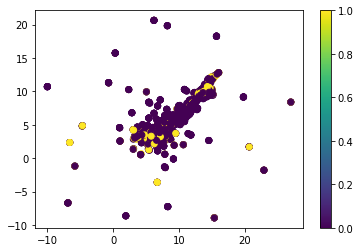

In [22]:
plt.scatter(embedding[:,0], embedding[:,1], c=train_y)
plt.colorbar()

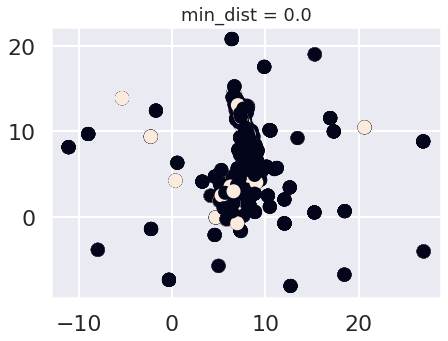

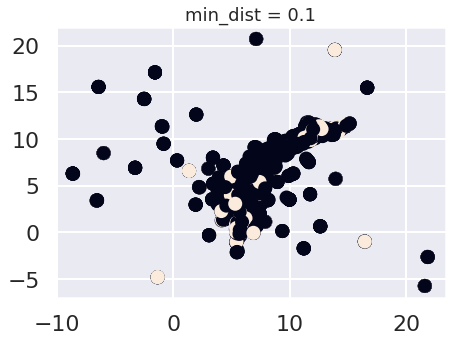

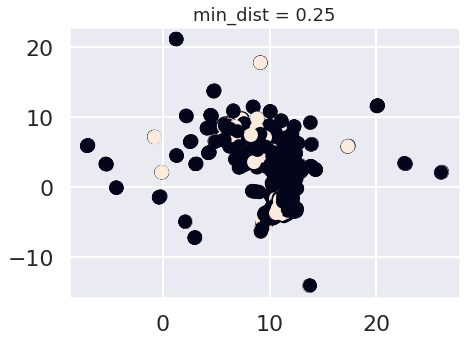

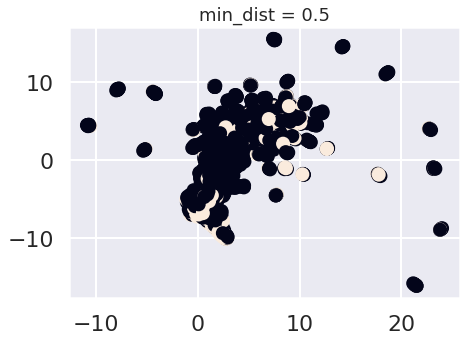

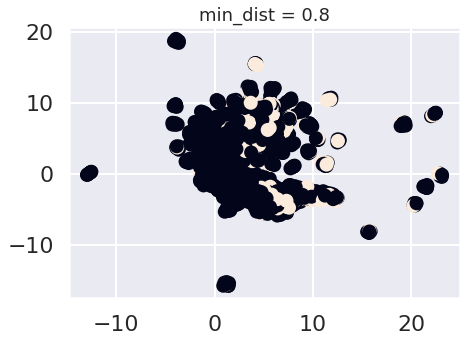

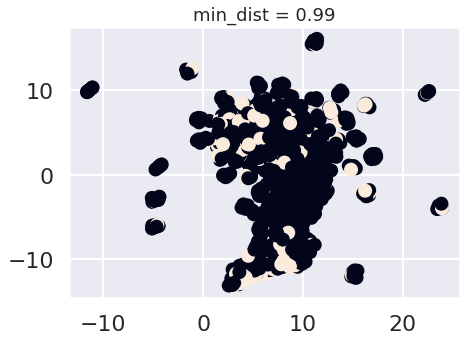

In [91]:
data_list = train_y
for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
    draw_umap(data, min_dist=d, title='min_dist = {}'.format(d))

/home/anahoban/lensing/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/anahoban/lensing/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/anahoban/lensing/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


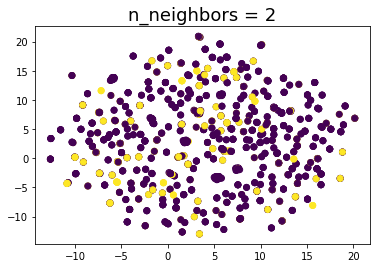

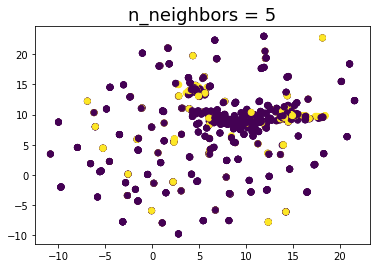

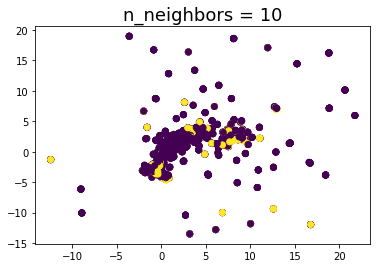

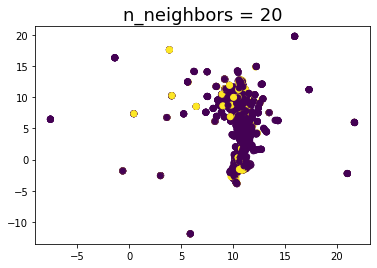

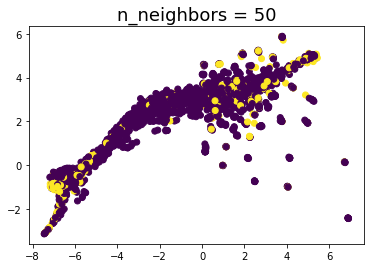

In [24]:
data_list=train_y
for n in (2, 5, 10, 20, 50):
    draw_umap(data, n_neighbors=n, title='n_neighbors = {}'.format(n))

--- 
# Data Augmentation

In [102]:
train_x = np.array(train_x)
train_y = np.array(train_y)

In [106]:
#create data generator
datagen = keras.preprocessing.image.ImageDataGenerator(
            featurewise_center=True,
            featurewise_std_normalization=True,
            rotation_range=180,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=[0.75,1],
            zoom_range=0.2,
            horizontal_flip=True,
            )
#create iterator (in train_classifier fct)
it = datagen.flow(train_x,train_y,batch_size=1)

In [107]:
it.next()

TypeError: bad operand type for unary -: 'list'

AttributeError: 'function' object has no attribute 'astype'

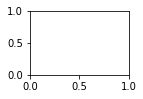

In [69]:
# generate samples and plot
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next
	# convert to unsigned integers for viewing
	image = batch.astype('uint8')
	# plot raw pixel data
	plt.imshow(image)
# show the figure
pyplot.show()


---

# Create and train classifier

In [81]:
def train_classifier(model, train_x, train_y, val_x, val_y, n_epochs, batch_size):
    train_steps = len(train_y) // batch_size
    val_steps = len(val_y) // batch_size
#     history = model.fit(iterator, 
#                         epochs=n_epochs,
#                         validation_data = (val_x, val_y), 
#                         callbacks=[callback])#, class_weight=class_weight)
    
    # fits the model on batches with real-time data augmentation:
    model.fit(
             datagen.flow(train_x, train_y, batch_size=batch_size),
             validation_data=datagen.flow(val_x, val_y,
             batch_size=batch_size),
             steps_per_epoch=train_steps,
             epochs=n_epochs
             )
    
    return model, history

def evaluate_model(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x_test, y_test)
    y_predict = model.predict(x_test)
    plt.hist(y_predict)
    print("Lowest 10 scores:")
    print(sorted(y_predict)[:10])
    print()
    print("Highest 10 scores:")
    print()
    print(sorted(y_predict)[-10:])
    conf = tf.math.confusion_matrix(y_test, y_predict)
    print(f"Confusion Matrix:\n {conf}")
    print("Test loss: %.3f" % test_loss)
    print("Test accuracy: %3f" % test_acc)
    return y_predict

def custom_loss_all(y_true, y_pred):
    return keras.losses.MSE(y_true*np.sqrt(weights_all), y_pred*np.sqrt(weights_all))

In [73]:
for i in range(len(encoder.layers)):
    encoder.layers[i].trainable = False

In [74]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr*tf.math.exp(-0.1)
    
def step_decay(epoch):
    initial_lrate = 5e-6
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * tf.math.pow(drop,  
           tf.math.floor((1+epoch)/epochs_drop))
    return lrate

In [19]:
#classifier = keras.models.load_model("../Models/binary_classifier")

In [22]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 64, 64, 32)        736       
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               16777344  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 16,786,401
Trainable params: 16,785,665
Non-trainable params: 736
_________________________________________________________________


In [ ]:
#keras.utils.plot_model(classifier, to_file="../Models/binary_classifier.png", show_shapes=True, show_layer_names=True)

In [75]:
initial_bias = np.log([num_rand/num_cands])

In [76]:
%autoreload
cutout_size = 64
classifier = create_classifier(encoder, initial_bias)
optimizer = keras.optimizers.Adam(learning_rate=5e-4)
callback = keras.callbacks.LearningRateScheduler(scheduler)
classifier.compile(optimizer=optimizer, loss="binary_crossentropy", metrics="accuracy")

In [82]:
N_EPOCHS = 50
BATCH_SIZE = 256
(classifier, history) = train_classifier(classifier, train_x, train_y,val_x, val_y, n_epochs = N_EPOCHS, batch_size = BATCH_SIZE)
#classifier.save("../Models/binary_classifier_alt")
hist_df = pd.DataFrame(history.history) 

hist_csv_file = '../Histories/history_binary_classifier_alt.csv'
with open(hist_csv_file, mode='a') as f:
    hist_df.to_csv(f)

TypeError: bad operand type for unary -: 'list'

Text(0.5, 1.0, 'accuracy')

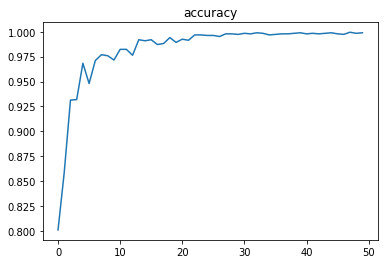

In [44]:
plt.plot(history.history['accuracy'])
plt.title('accuracy')

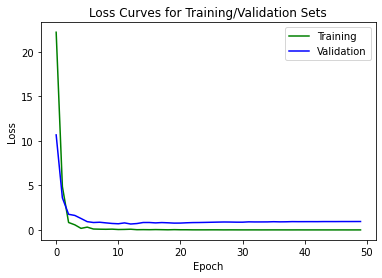

In [45]:
plot_loss_curves(history.history, figname="binary_classifier_alt.png")

---
## Testing

9/9 [==============================] - 0s 9ms/step - loss: 0.7418 - accuracy: 0.8989
Lowest 10 scores:
[array([5.665621e-16], dtype=float32), array([3.0783608e-15], dtype=float32), array([5.6771113e-15], dtype=float32), array([1.2736231e-14], dtype=float32), array([9.362836e-14], dtype=float32), array([1.9494705e-13], dtype=float32), array([1.941849e-12], dtype=float32), array([6.250123e-12], dtype=float32), array([9.3271085e-12], dtype=float32), array([1.5307365e-11], dtype=float32)]

Highest 10 scores:

[array([0.9910484], dtype=float32), array([0.9942198], dtype=float32), array([0.9995197], dtype=float32), array([0.9997242], dtype=float32), array([0.9997373], dtype=float32), array([0.99975735], dtype=float32), array([0.99979705], dtype=float32), array([0.99997854], dtype=float32), array([0.99999964], dtype=float32), array([1.], dtype=float32)]
Confusion Matrix:
 [[231   0]
 [ 35   1]]
Test loss: 0.742
Test accuracy: 0.898876


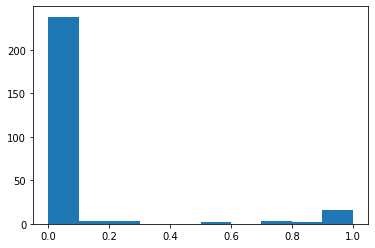

In [46]:
pred_label = evaluate_model(classifier, test_x, test_y)

---- 
# ROC curve
Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.
Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

In [36]:
from sklearn import metrics

In [47]:
fpr, tpr, thresholds = metrics.roc_curve(y_true = test_y, y_score = pred_label)
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(test_y))]

In [48]:
ns_auc = metrics.roc_auc_score(test_y, ns_probs)
lr_auc = metrics.roc_auc_score(test_y, pred_label)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.813


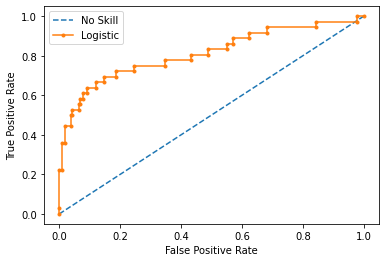

In [49]:
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = metrics.roc_curve(test_y, ns_probs)
lr_fpr, lr_tpr, _ = metrics.roc_curve(test_y, pred_label)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

hf_pos.close()
hf_neg.close()